<a href="https://colab.research.google.com/github/krishnamoji/12C-alpha/blob/main/SeccionNuclear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sección Nuclear

## Librerias

In [5]:
import matplotlib.pyplot as plt
from mpmath import *
import numpy as np
from scipy.special import legendre
from scipy import linalg as lg

## Funciones

In [6]:
def f(r,R,a):  return (1+np.exp((r-R)/a))**(-1)

def Vc(r,Rc):
    K = 6*2*1.44 # K=6e^2 donde e^2=1.44 MeV fm
    if r<Rc:  return K*(3*Rc**2-r**2) / (2*Rc**3) #K/Rc
    else:     return K/r

def U(r): #potencial
    A  = 12 #12C
    R  = 1.22 * A**(1/3) #A=A1**(1/3)+A2**(1/3)
    a  = 0.76
    Rp = 1.85 * A**(1/3)
    ap = 0.47
    Rc = 1.26 * A**(1/3)
    return  Vc(r,Rc) - 108.1*f(r,R,a) - 16.9*1j*f(r,Rp,ap)

def sigma(l,eta):
    U = mp.gamma(1+l+eta*(1j)) #U=mp.gamma(1+l+eta*1j)
    O = np.float64(phase(U))   #O=np.atan2(U.imag,U.real)  #O=atan2(U.imag/U.real) #np.angle
    if O<0:  O = O + 2*np.pi
    return O

def sigma0(eta):
    U = mp.gamma(1+eta*(1j))
    return np.float64(mp.phase(U))

def ruther(theta,a):
    return (a**2/4) * (1/np.sin(theta/2)**4)

def P(x,n):
    leg = legendre(n)
    Pn  = leg(x)
    return Pn

# ------------------------- ------------
def funcion(x,a,k,n):
    leg = np.polynomial.legendre.Legendre.basis(n)
    return (-1)**(n-k+1)*(x/(a*X[k]))*np.sqrt(a*X[k]*(1-X[k]))*(leg((2*x/a)-1)/(x-a*X[k]))

# ------------------------- ------------
def fc(theta,a,eta):
    return -(a/2)*np.exp(2*sigma0(eta)*(1j))*(np.exp(-1j*eta*np.log(np.sin(theta/2)**2))/np.sin(theta/2)**2)

def fn(x,eta):
    Fn = 0
    for m in range(0,n):
        Fn = Fn + (2*m+1)*P(np.cos(x),m)*np.exp(2*sigma(m,eta)*1j)*(S[m]-1) 
    return Fn / (2*k*1j)

def seccion(theta):     return np.absolute(fc(theta,a,eta)+fn(theta,eta))**2

System parameters

In [7]:
Z1, Z2 = 6, 2   # Numeros 
A1, A2 = 4, 12  #12C, #particula alfa
a = 15
Cte = 20.736 * (A1+A2) / (A1*A2) #C=(hbar**2)/(2*m)
# K=6e^2 donde e^2=1.44 MeV fm

E = 139 * A2 / (A1+A2) 
k = np.sqrt(E/Cte)
n = 60 #np.int(a*k)  #grado del polinomio)
eta = (Z1*Z2*1.44) / (2*Cte*k)

barrera = (Z1*Z2*1.44)/(1.3*(A1**(1/3)+A2**(1/3)))

[X,W] = np.polynomial.legendre.leggauss(n) #Se guarda los ceros en X[i] y los pesos en W[i] # Estan entre (-1,1)
X = [(X[i]+1)/2 for i in range(n)]

Creating arrays

In [13]:
'''
T = np.zeros((n,n))
V = np.zeros((n,n))
H = np.zeros((n,n))
C = np.zeros((n,n))

S    = zeros((n))
ejeX = np.zeros((n))
Real = np.zeros((n))
Imag = np.zeros((n))
abso = np.zeros((n))
l = 0
'''
T=[]
for i in range (n):    T.append([0]*n)
V=[]
for i in range (n):    V.append([0]*n)    
H=[]
for i in range (n):    H.append([0]*n)    
C=[]
for i in range (n):    C.append([0]*n) 
S    = [0]*n
ejeX = [0]*n
Real = [0]*n
Imag = [0]*n
abso = [0]*n
#'''

Operación de matrices

$T = (\frac{1}{a})$

In [14]:
l = 0
for b in range(0,n): 
  # ---------------------------
    for i in range(0,n):
        for m in range(0,n):
            if(i==m):
                T[i][m] = (1/a**2)*Cte*((4*n**2+4*n+3)*X[i]*(1-X[i])-6*X[i]+1)/(3*X[i]**2*(1-X[i])**2)
                V[i][m] = U(X[i]*a)+Cte*l*(l+1)/((X[i]*a)**2) 
                H[i][m] = T[i][m]+V[i][m]
                C[i][m] = H[i][m]-E
            else:
                T[i][m] = (1/a**2)*Cte*(((-1)**(i+m)/np.sqrt(X[i]*X[m]*(1-X[i])*(1-X[m])))*(n**2+n+1+(X[i]+X[m]-2*X[i]*X[m])/((X[i]-X[m])**2)-1/(1-X[i])-1/(1-X[m])))
                V[i][m] = 0
                H[i][m] = T[i][m]+V[i][m]
                C[i][m] = H[i][m]
    # ---------------------------
    
    inverse = lg.inv(C) #matriz inversa
    
    R = 0
    for g in range(0,n):
        for m in range(0,n):
            R = R + (Cte/a)*funcion(a,a,g,n)*inverse[g][m]*funcion(a,a,m,n)
    
    eta = (Z1*Z2*1.44) / (2*Cte*k)    #1.28900677327098  #parametro de Sommerfeld
    
    #------ creando las funciones de Coulomb y sus derivadas  ------------------
    F    = lambda x: coulombf(l,eta,x)
    G    = lambda x: coulombg(l,eta,x)
    derF = lambda x: diff(F,x)   # 
    derG = lambda x: diff(G,x)
    
    # ---------------
    Hplus  = G(k*a)    + j*F(k*a)
    Hminus = G(k*a)    - j*F(k*a)
    Hpder  = derG(k*a) + j*derF(k*a)
    Hmder  = derG(k*a) - j*derF(k*a)
    
    S[b]   = (Hminus - a*k*R*Hmder) / (Hplus - a*k*R*Hpder)
    
    l+=1

## Plotting 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


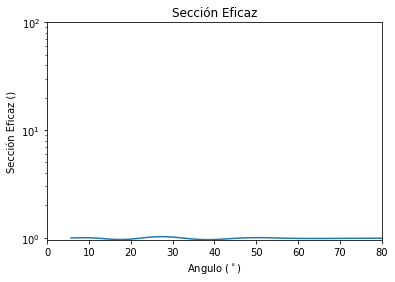

In [21]:
# ----------- variables --------------------
theta = np.linspace(0.1,np.pi/2,100)
y1    = [seccion(theta[i])/ruther(theta[i],a) for i in range(len(theta))]

# --------- plotting ------------------
plt.semilogy(degrees(theta), y1)
plt.yscale("log")
plt.ylim((0,100)); plt.xlim((0,80))
plt.xlabel('Angulo ($^\circ$)'); plt.ylabel('Sección Eficaz ()')
plt.title('Sección Eficaz')
plt.show()